## **MNIST**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Reshape, Conv2DTranspose, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanSquaredError as MSE, MeanAbsoluteError as MAE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_val = np.reshape(x_val, (len(x_val), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

* train AutoEncoder *

In [ ]:
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

encoded = Flatten()(x)
encoded = Dense(32, activation='relu',name='encoded_layer')(encoded)

x = Dense(7*7*64, activation='relu')(encoded)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
decoded_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='decoded_output')(x)

autoencoder = Model(inputs=input_img, outputs=[decoded_output, encoded])
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
autoencoder.compile(optimizer=optimizer , loss = {'decoded_output' : 'mean_squared_error'} , metrics={'decoded_output': [MSE(), MAE()]})

early_stopping = EarlyStopping(monitor='val_decoded_output_loss', patience=5, restore_best_weights=True)
history = autoencoder.fit(x_train, {'decoded_output': x_train}, epochs=10 , batch_size=256 , shuffle=True ,
                          validation_data=(x_val, {'decoded_output': x_val}) , callbacks=[early_stopping])

Epoch 1/10
176/176 [==============================] - 5s 20ms/step - loss: 0.0722 - decoded_output_loss: 0.0722 - decoded_output_mean_squared_error: 0.0722 - decoded_output_mean_absolute_error: 0.1532 - val_loss: 0.0360 - val_decoded_output_loss: 0.0360 - val_decoded_output_mean_squared_error: 0.0360 - val_decoded_output_mean_absolute_error: 0.0846
Epoch 2/10
176/176 [==============================] - 3s 19ms/step - loss: 0.0232 - decoded_output_loss: 0.0232 - decoded_output_mean_squared_error: 0.0232 - decoded_output_mean_absolute_error: 0.0606 - val_loss: 0.0162 - val_decoded_output_loss: 0.0162 - val_decoded_output_mean_squared_error: 0.0162 - val_decoded_output_mean_absolute_error: 0.0468
Epoch 3/10
176/176 [==============================] - 3s 19ms/step - loss: 0.0137 - decoded_output_loss: 0.0137 - decoded_output_mean_squared_error: 0.0137 - decoded_output_mean_absolute_error: 0.0415 - val_loss: 0.0120 - val_decoded_output_loss: 0.0120 - val_decoded_output_mean_squared_error: 0.0

# Provide Summary and Plot Loss and Accuracy

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0   

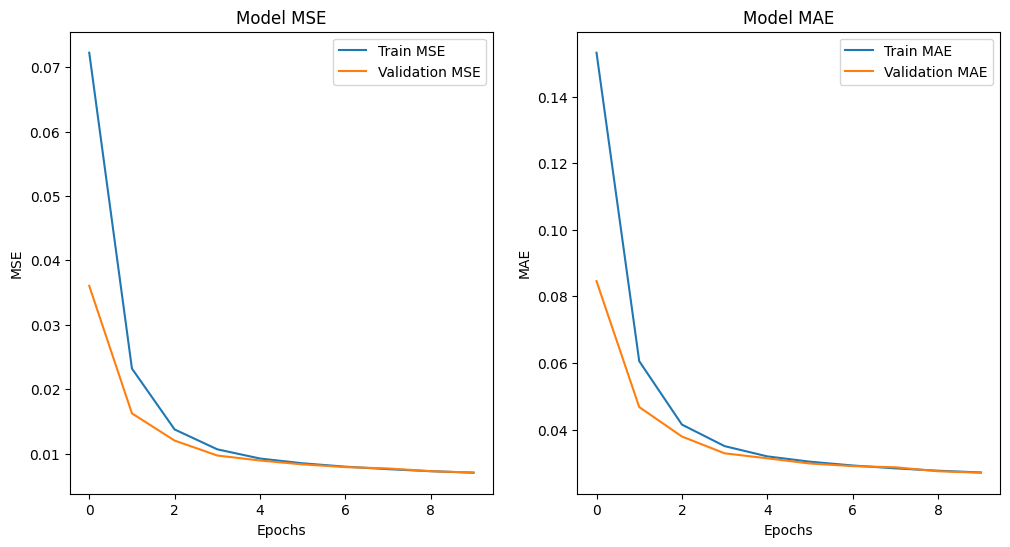

313/313 [==============================] - 1s 2ms/step


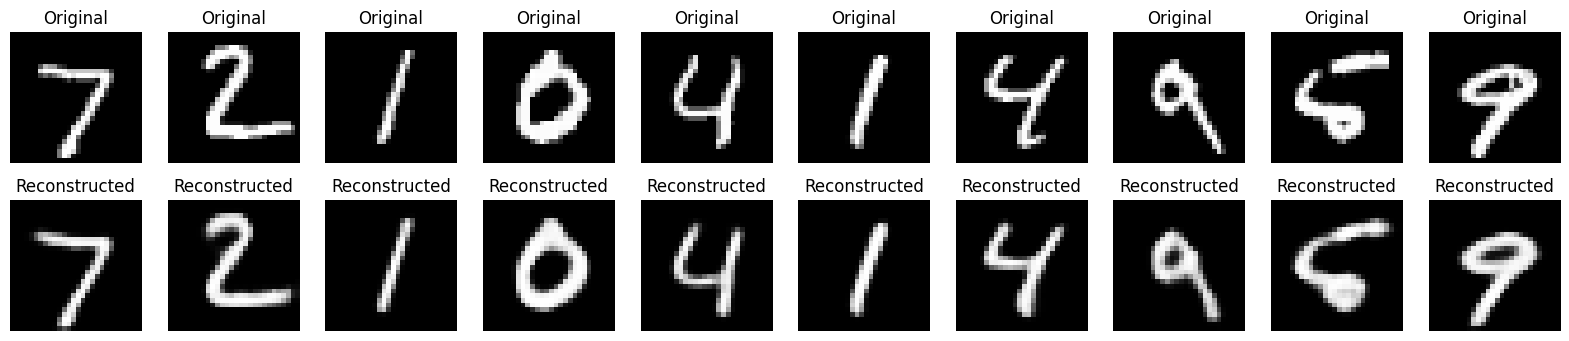

In [ ]:
autoencoder.summary()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['decoded_output_mean_squared_error'], label='Train MSE')
plt.plot(history.history['val_decoded_output_mean_squared_error'], label='Validation MSE')
plt.title('Model MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['decoded_output_mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_decoded_output_mean_absolute_error'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

decoded_imgs = autoencoder.predict(x_test)[0]

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()

In [ ]:
features_train = autoencoder.predict(x_train)[1]
features_val = autoencoder.predict(x_val)[1]
features_test = autoencoder.predict(x_test)[1]

features = np.concatenate((features_train, features_val, features_test), axis=0)
labels = np.concatenate((y_train, y_val, y_test), axis=0)

# KMeans , Silhouette Score

def find_best_k(features):
    silhouette_scores = []
    K_range = range(5, 16)
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
        cluster_labels = kmeans.fit_predict(features)
        silhouette_avg = silhouette_score(features, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f'For n_clusters = {k}, the silhouette score is {silhouette_avg:.4f}')
    return silhouette_scores

silhouette_scores_mnist = find_best_k(features)

313/313 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5, the silhouette score is 0.1314


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6, the silhouette score is 0.1342


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 7, the silhouette score is 0.1390


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 8, the silhouette score is 0.1267


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 9, the silhouette score is 0.1260


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 10, the silhouette score is 0.1241


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 11, the silhouette score is 0.1251


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 12, the silhouette score is 0.1213


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 13, the silhouette score is 0.1229


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 14, the silhouette score is 0.1226


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 15, the silhouette score is 0.1236


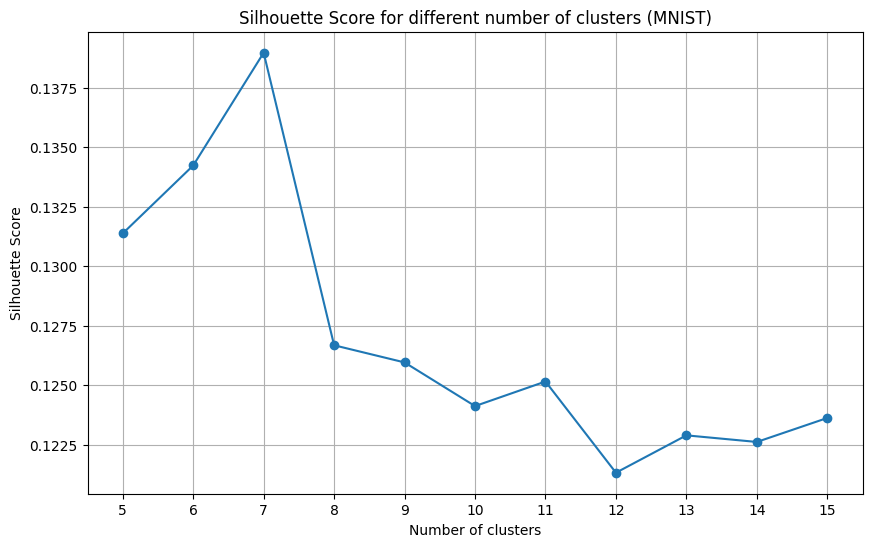

The best number of clusters is 7


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


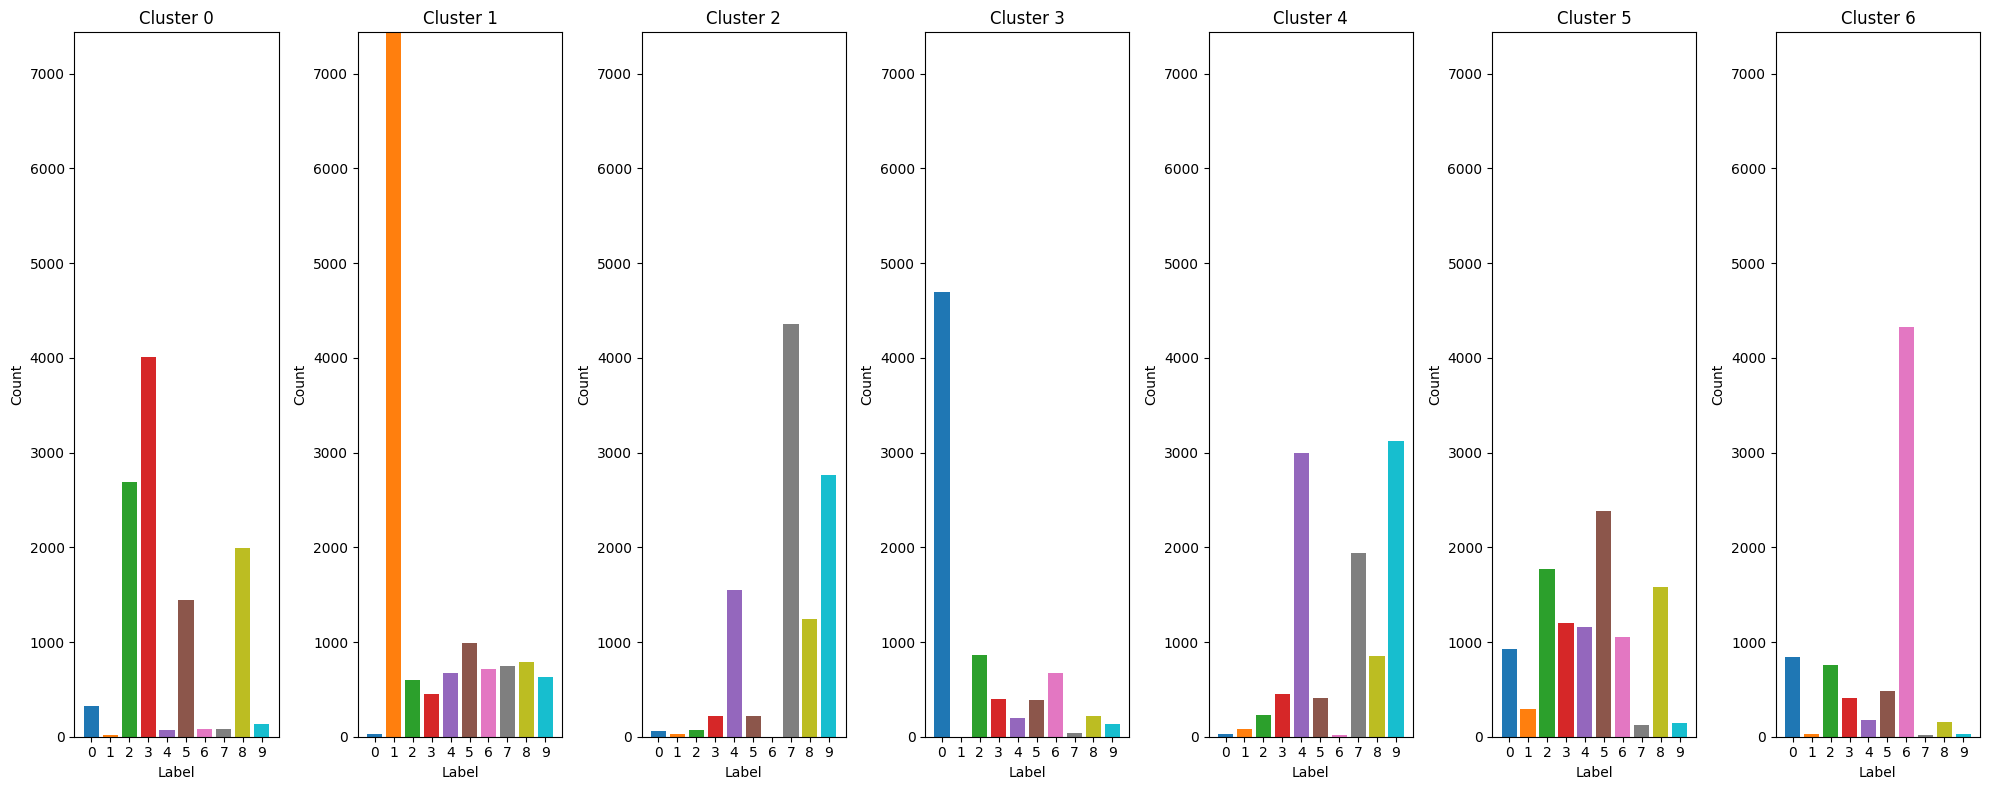

Cluster 0 percentages: [ 3.00092336  0.16620499 24.83841182 37.01754386  0.60941828 13.28716528
  0.78485688  0.72022161 18.35641736  1.21883657]
Cluster 1 percentages: [ 0.191659   56.93805581  4.61514873  3.44986201  5.15946029  7.55136461
  5.51977921  5.70377185  6.04875805  4.82214045]
Cluster 2 percentages: [6.18046972e-01 2.75744033e-01 7.03622706e-01 2.08234287e+00
 1.47190263e+01 2.10135970e+00 9.50841495e-03 4.14281639e+01
 1.18189598e+01 2.62432253e+01]
Cluster 3 percentages: [61.67696149  0.         11.4075437   5.20436325  2.61532396  5.07293994
  8.8185044   0.47312393  2.90445525  1.82678407]
Cluster 4 percentages: [ 0.28644804  0.80007902  2.30146187  4.43500593 29.61280126  4.03002766
  0.16791782 19.12287633  8.40576847 30.83761359]
Cluster 5 percentages: [ 8.66704268  2.74487686 16.61966535 11.32731716 10.89490506 22.42902801
  9.91727768  1.19383343 14.85241587  1.3536379 ]
Cluster 6 percentages: [11.66067975  0.41447914 10.4310583   5.70599613  2.5006908   6.742193

In [ ]:
K_range = range(5, 16)
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores_mnist, marker='o')
plt.title('Silhouette Score for different number of clusters (MNIST)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(K_range)
plt.grid(True)
plt.show()

best_k = K_range[np.argmax(silhouette_scores_mnist)]

print(f'The best number of clusters is {best_k}')

kmeans = KMeans(n_clusters=best_k, random_state=42,init='k-means++')
cluster_labels = kmeans.fit_predict(features)

cluster_counts = np.zeros((best_k, 10), dtype=int)
for i in range(len(labels)):
    cluster_counts[cluster_labels[i], labels[i]] += 1

colors = plt.cm.tab10.colors

plt.figure(figsize=(20, 8))
for cluster in range(best_k):
    plt.subplot(1, best_k, cluster + 1)
    plt.bar(np.arange(10), cluster_counts[cluster], color=colors)
    plt.title(f'Cluster {cluster}')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(np.arange(10))
    plt.ylim(0, np.max(cluster_counts) + 10)
plt.tight_layout()
plt.show()

for cluster in range(best_k):
    total = np.sum(cluster_counts[cluster])
    percentages = (cluster_counts[cluster] / total) * 100
    print(f'Cluster {cluster} percentages: {percentages}')

# **FashionMnist**

In [ ]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_val = np.reshape(x_val, (len(x_val), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

4422102/4422102 [==============================] - 2s 0us/step


In [ ]:
history = autoencoder.fit(x_train, {'decoded_output': x_train},
                          epochs=10,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_val, {'decoded_output': x_val}),
                          callbacks=[early_stopping])

Epoch 1/10
176/176 [==============================] - 4s 20ms/step - loss: 0.0205 - decoded_output_loss: 0.0205 - decoded_output_mean_squared_error: 0.0205 - decoded_output_mean_absolute_error: 0.0778 - val_loss: 0.0144 - val_decoded_output_loss: 0.0144 - val_decoded_output_mean_squared_error: 0.0144 - val_decoded_output_mean_absolute_error: 0.0640
Epoch 2/10
176/176 [==============================] - 3s 19ms/step - loss: 0.0134 - decoded_output_loss: 0.0134 - decoded_output_mean_squared_error: 0.0134 - decoded_output_mean_absolute_error: 0.0605 - val_loss: 0.0125 - val_decoded_output_loss: 0.0125 - val_decoded_output_mean_squared_error: 0.0125 - val_decoded_output_mean_absolute_error: 0.0580
Epoch 3/10
176/176 [==============================] - 3s 20ms/step - loss: 0.0121 - decoded_output_loss: 0.0121 - decoded_output_mean_squared_error: 0.0121 - decoded_output_mean_absolute_error: 0.0566 - val_loss: 0.0116 - val_decoded_output_loss: 0.0116 - val_decoded_output_mean_squared_error: 0.0

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0   

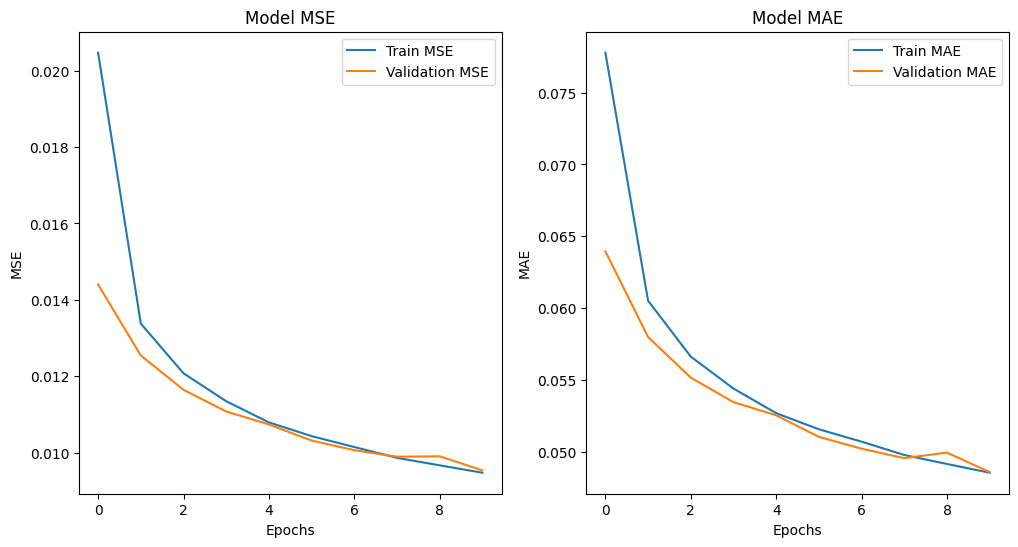

313/313 [==============================] - 1s 2ms/step


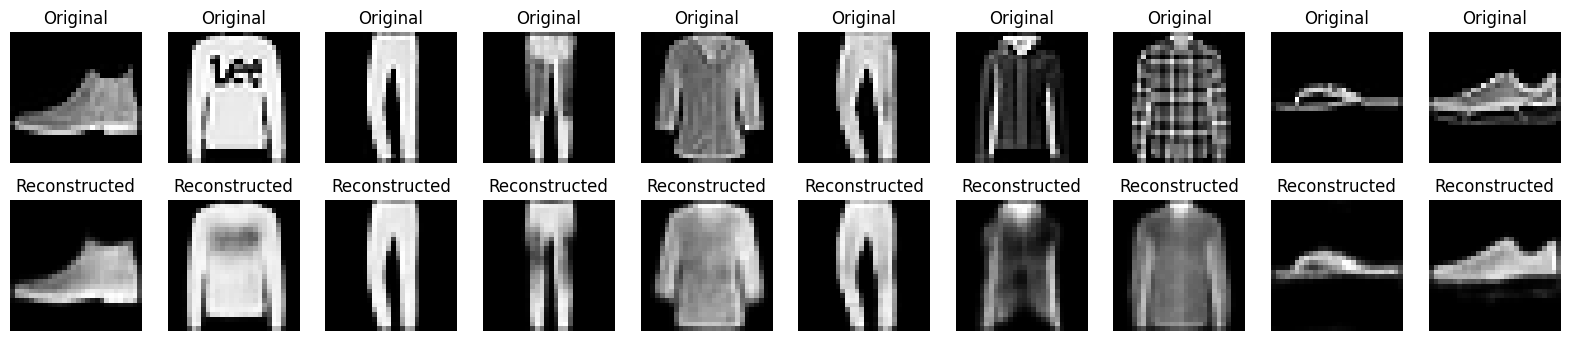

In [ ]:
autoencoder.summary()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['decoded_output_mean_squared_error'], label='Train MSE')
plt.plot(history.history['val_decoded_output_mean_squared_error'], label='Validation MSE')
plt.title('Model MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['decoded_output_mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_decoded_output_mean_absolute_error'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

decoded_imgs = autoencoder.predict(x_test)[0]


n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()


In [ ]:
features_train = autoencoder.predict(x_train)[1]
features_val = autoencoder.predict(x_val)[1]
features_test = autoencoder.predict(x_test)[1]

features = np.concatenate((features_train, features_val, features_test), axis=0)
labels = np.concatenate((y_train, y_val, y_test), axis=0)

def find_best_k(features):
    silhouette_scores = []
    K_range = range(5, 16)
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
        cluster_labels = kmeans.fit_predict(features)
        silhouette_avg = silhouette_score(features, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f'For n_clusters = {k}, the silhouette score is {silhouette_avg:.4f}')
    return silhouette_scores

silhouette_scores_mnist = find_best_k(features)

313/313 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5, the silhouette score is 0.2404


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6, the silhouette score is 0.2357


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 7, the silhouette score is 0.2444


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 8, the silhouette score is 0.2347


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 9, the silhouette score is 0.2181


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 10, the silhouette score is 0.2170


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 11, the silhouette score is 0.2245


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 12, the silhouette score is 0.2182


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 13, the silhouette score is 0.2038


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 14, the silhouette score is 0.1909


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 15, the silhouette score is 0.1949


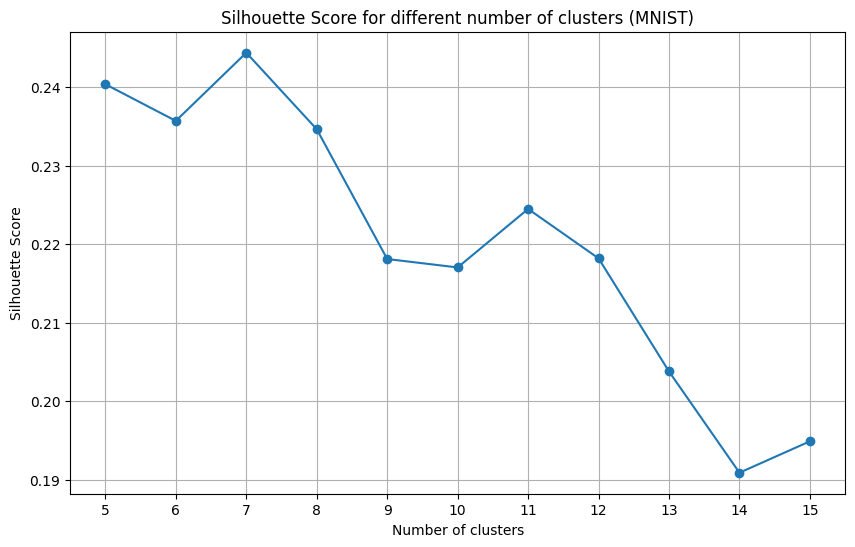

The best number of clusters is 7


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


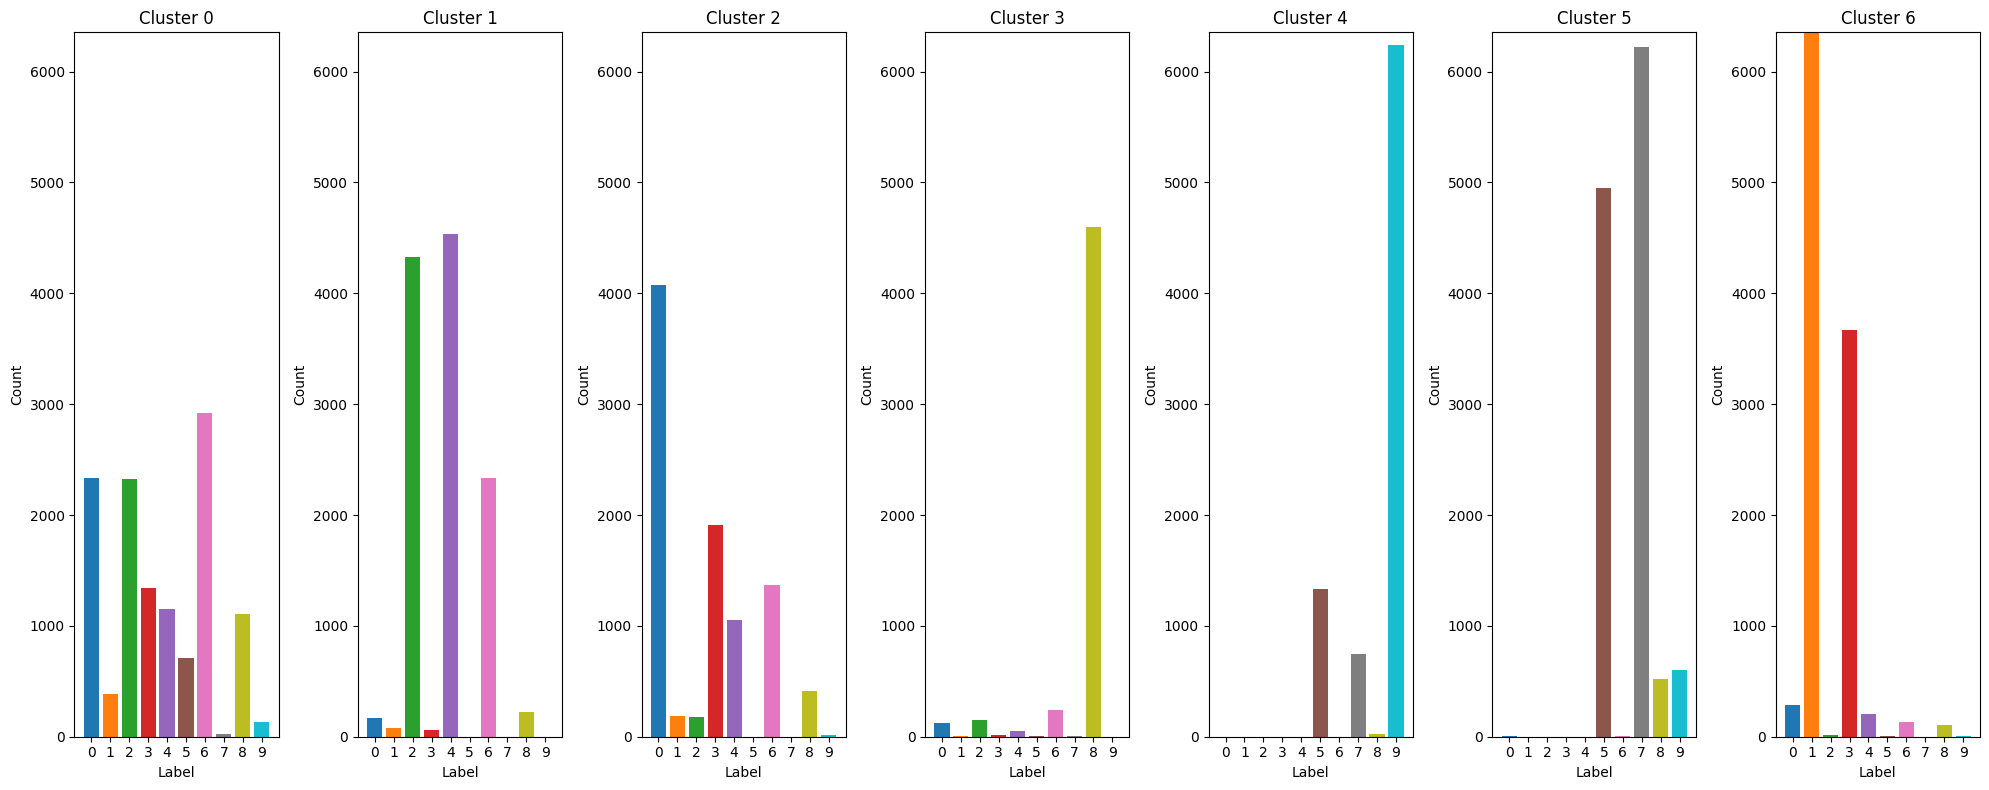

Cluster 0 percentages: [18.76257141  3.08150294 18.69820581 10.80537453  9.26060021  5.704401
 23.46125996  0.23332529  8.92268083  1.07007804]
Cluster 1 percentages: [1.46670078e+00 6.90713738e-01 3.69062846e+01 4.94585145e-01
 3.86629146e+01 0.00000000e+00 1.98686791e+01 0.00000000e+00
 1.89306728e+00 1.70546602e-02]
Cluster 2 percentages: [4.42514385e+01 2.03018130e+00 1.94332863e+00 2.07469330e+01
 1.14536967e+01 1.08565845e-02 1.49060905e+01 0.00000000e+00
 4.49462599e+00 1.62848768e-01]
Cluster 3 percentages: [2.40107568e+00 7.68344218e-02 2.91970803e+00 3.45754898e-01
 1.03726469e+00 7.68344218e-02 4.64848252e+00 5.76258164e-02
 8.83980023e+01 3.84172109e-02]
Cluster 4 percentages: [1.19789171e-02 0.00000000e+00 1.19789171e-02 0.00000000e+00
 0.00000000e+00 1.59798754e+01 0.00000000e+00 8.97220891e+00
 2.51557259e-01 7.47724006e+01]
Cluster 5 percentages: [4.06371912e-02 8.12743823e-03 8.12743823e-03 0.00000000e+00
 0.00000000e+00 4.02145644e+01 4.87646294e-02 5.05445384e+01
 4.

In [ ]:
K_range = range(5, 16)
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores_mnist, marker='o')
plt.title('Silhouette Score for different number of clusters (MNIST)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(K_range)
plt.grid(True)
plt.show()

best_k = K_range[np.argmax(silhouette_scores_mnist)]

print(f'The best number of clusters is {best_k}')

kmeans = KMeans(n_clusters=best_k, random_state=42,init='k-means++')
cluster_labels = kmeans.fit_predict(features)

cluster_counts = np.zeros((best_k, 10), dtype=int)
for i in range(len(labels)):
    cluster_counts[cluster_labels[i], labels[i]] += 1

colors = plt.cm.tab10.colors

plt.figure(figsize=(20, 8))
for cluster in range(best_k):
    plt.subplot(1, best_k, cluster + 1)
    plt.bar(np.arange(10), cluster_counts[cluster], color=colors)
    plt.title(f'Cluster {cluster}')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(np.arange(10))
    plt.ylim(0, np.max(cluster_counts) + 10)
plt.tight_layout()
plt.show()

for cluster in range(best_k):
    total = np.sum(cluster_counts[cluster])
    percentages = (cluster_counts[cluster] / total) * 100
    print(f'Cluster {cluster} percentages: {percentages}')